## Get the Data

In [13]:
import pandas as pd

df = pd.read_csv("../Data/cleaned_dataset.csv")
df

,Mean Temperature,Mean Pressure,Rainfall,Relative Humidity,Mean Cloud,Evaporation,Global Solar Radiation,Max UV,Wind Speed,Mean UV,...,RSP,O3,FSP,Intensity,Signal,Duration(hr min),day_sin,day_cos,wind_sin,wind_cos
0,15.4,1025.1,0.00,68.0,57.0,3.4,18.11,10.072187,6.730814,4.592663,...,43.0,0.0,31.0,0.0,0.0,0.0,0.999991,0.004304,0.173648,0.984808
1,16.6,1025.8,0.00,69.0,79.0,3.1,12.94,9.279723,8.470005,3.780165,...,57.0,0.0,37.0,0.0,0.0,0.0,0.999917,-0.012910,0.173648,0.984808
2,17.5,1023.0,0.00,69.0,53.0,4.0,20.32,10.851292,6.246643,5.183114,...,51.0,0.0,37.0,0.0,0.0,0.0,0.999546,-0.030120,0.173648,0.984808
3,18.5,1018.7,0.00,78.0,89.0,2.8,12.21,11.371977,10.663324,4.197858,...,53.0,-0.0,33.0,0.0,0.0,0.0,0.998880,-0.047321,0.342020,0.939693
4,19.7,1014.7,0.05,85.0,90.0,1.6,11.50,10.239657,11.126056,3.814848,...,54.0,-0.0,33.0,0.0,0.0,0.0,0.997917,-0.064508,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12157,27.3,1009.3,0.05,73.0,77.0,3.1,9.52,4.000000,12.200000,2.000000,...,24.0,65.0,18.0,0.0,0.0,0.0,-0.891981,0.452072,0.984808,-0.173648
12158,25.8,1010.1,0.05,67.0,83.0,3.0,6.97,4.000000,9.700000,2.000000,...,16.0,28.0,11.0,0.0,0.0,0.0,-0.884068,0.467359,0.500000,0.866025
12159,25.3,1011.1,0.05,69.0,86.0,3.0,9.41,6.000000,8.400000,2.000000,...,19.0,31.0,14.0,0.0,0.0,0.0,-0.875892,0.482508,0.500000,0.866025
12160,26.2,1010.3,0.00,64.0,70.0,5.0,18.57,7.000000,8.300000,3.000000,...,28.0,36.0,20.0,0.0,0.0,0.0,-0.867456,0.497513,0.500000,0.866025


## Environment Setup

In [14]:

## RNN

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import random
import warnings
from torch.utils.data import DataLoader
from tqdm import tqdm
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data processing

In [15]:
target_cols = "Mean Temperature"
feautures_cols = [col for col in df.columns if col != target_cols]

target = df[target_cols].values
feature = df[feautures_cols].values

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()


target_scaled = scaler_target.fit_transform(target.reshape(-1, 1))
features_scaled = scaler_features.fit_transform(feature)

combined_features = np.concatenate([features_scaled, target_scaled], axis=1)

In [16]:
sequence_length = 30
def create_dataset(data, target, seq_length=1):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_dataset(combined_features, target_scaled, sequence_length)
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

In [17]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model

In [18]:
class EnhancedRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(EnhancedRNNModel, self).__init__()

        # LSTM instead of RNN
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM returns: output, (hidden, cell)
        out, _ = self.lstm(x)  # out: (batch, sequence_length, hidden_size)
        out = out[:, -1, :]    # Take the last time step: (batch, hidden_size)
        out = self.fc(out)     # (batch, output_size)
        return out

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5, device='cpu'):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')  # Track best validation loss
    patience_counter = 0  # Count epochs without improvement

    # Wrap the epoch loop with tqdm for a progress bar
    epoch_bar = tqdm(range(num_epochs), desc="Training Progress", unit="epoch")
    for epoch in epoch_bar:
        model.train()
        running_loss = 0.0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                loss = criterion(outputs, targets)
                val_running_loss += loss.item()

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)

        # Update epoch progress bar with current losses
        epoch_bar.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if validation loss improves
            # Save the best model
            torch.save(model.state_dict(), 'best_lstm_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                epoch_bar.write(f"Early stopping triggered after {epoch+1} epochs (no improvement for {patience} epochs).")
                # Load the best model state before exiting
                model.load_state_dict(torch.load('best_lstm_model.pth'))
                break

    # Plot training and validation loss
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('RNN Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    return train_losses, val_losses

In [20]:
def evaluate_model(model, test_loader, scaler_target, device='cpu'):
    # Ensure model is on the correct device
    model.to(device)
    model.eval()
    predictions = []
    actuals = []

    # Collect predictions and actuals
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())

    # Concatenate
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    # Debugging: Print first 5 scaled predictions
    print("First 5 scaled predictions:", predictions[:5].flatten())

    # Inverse transform
    predictions = scaler_target.inverse_transform(predictions)
    actuals = scaler_target.inverse_transform(actuals)

    # Debugging: Print first 5 inverse-transformed predictions
    print("First 5 inverse-transformed predictions:", predictions[:5].flatten())

    return predictions, actuals

In [21]:
import os

def plot_performance(train_losses, val_losses, predictions, actuals, title = 'LSTM Model Performance'):
    plt.figure(figsize=(12, 10))

    plt.subplot(3, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(actuals, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title('LSTM Model Predictions vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Mean Temperature')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(actuals[-100:], label='Actual', color='blue')
    plt.plot(predictions[-100:], label='Predicted', color='red')
    plt.title('Zoomed-in LSTM Model Predictions vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Mean Temperature')
    plt.legend()

    plt.suptitle(title)

    path = 'results/'
    if not os.path.exists(path):
        os.makedirs(path)

    plt.savefig(path + title.replace(" ", "_") + '.png')
    plt.close()


In [22]:
def calculate_metrics(predictions, actuals):
    mse = mean_squared_error(actuals, predictions)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    return rmse, mae

## Check the best parameter

Training with Seq: 10, Hidden: 32, Layers: 1, LR: 0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training Progress:  54%|█████▍    | 54/100 [00:25<00:21,  2.09epoch/s, Train Loss=0.0017, Val Loss=0.0020]


Early stopping triggered after 55 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.4559149  0.51981056 0.29428807 0.43507558 0.4597643 ]
First 5 inverse-transformed predictions: [17.43766  19.19479  12.992922 16.864578 17.543518]
RMSE: 1.2015
MAE: 0.9411
RMSE: 1.2015085136280215, MAE: 0.9411352872848511
--------------------------------------------------
Training with Seq: 10, Hidden: 32, Layers: 2, LR: 0.001


Training Progress:  37%|███▋      | 37/100 [00:20<00:34,  1.81epoch/s, Train Loss=0.0018, Val Loss=0.0021]


Early stopping triggered after 38 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.47308618 0.521487   0.31292808 0.40940213 0.46631244]
First 5 inverse-transformed predictions: [17.90987  19.240892 13.505523 16.15856  17.72359 ]
RMSE: 1.1780
MAE: 0.9141
RMSE: 1.1780316181764656, MAE: 0.9141008853912354
--------------------------------------------------
Training with Seq: 10, Hidden: 32, Layers: 3, LR: 0.001


Training Progress:  30%|███       | 30/100 [00:17<00:41,  1.68epoch/s, Train Loss=0.0018, Val Loss=0.0021]


Early stopping triggered after 31 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.457006   0.5118004  0.28903943 0.4140491  0.46518475]
First 5 inverse-transformed predictions: [17.467665 18.974512 12.848585 16.28635  17.692581]
RMSE: 1.2680
MAE: 0.9905
RMSE: 1.268024007612086, MAE: 0.9905071258544922
--------------------------------------------------
Training with Seq: 10, Hidden: 64, Layers: 1, LR: 0.001


Training Progress:  56%|█████▌    | 56/100 [00:26<00:20,  2.11epoch/s, Train Loss=0.0016, Val Loss=0.0022]


Early stopping triggered after 57 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.47671157 0.52779216 0.28887475 0.45123062 0.4574426 ]
First 5 inverse-transformed predictions: [18.00957  19.414284 12.844056 17.308842 17.479671]
RMSE: 1.2179
MAE: 0.9746
RMSE: 1.2178605575417765, MAE: 0.9746178388595581
--------------------------------------------------
Training with Seq: 10, Hidden: 64, Layers: 2, LR: 0.001


Training Progress:  50%|█████     | 50/100 [00:26<00:26,  1.89epoch/s, Train Loss=0.0016, Val Loss=0.0020]


Early stopping triggered after 51 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.45736557 0.5127682  0.29740602 0.43732572 0.45154232]
First 5 inverse-transformed predictions: [17.477554 19.001125 13.078666 16.926458 17.317413]
RMSE: 1.2221
MAE: 0.9622
RMSE: 1.2221398771367047, MAE: 0.9622265696525574
--------------------------------------------------
Training with Seq: 10, Hidden: 64, Layers: 3, LR: 0.001


Training Progress:  41%|████      | 41/100 [00:25<00:36,  1.63epoch/s, Train Loss=0.0016, Val Loss=0.0020]


Early stopping triggered after 42 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.46469337 0.49482304 0.29598418 0.43473905 0.45431852]
First 5 inverse-transformed predictions: [17.679068 18.507633 13.039565 16.855324 17.393759]
RMSE: 1.2128
MAE: 0.9605
RMSE: 1.2128187271897963, MAE: 0.9604809284210205
--------------------------------------------------
Training with Seq: 10, Hidden: 128, Layers: 1, LR: 0.001


Training Progress:  41%|████      | 41/100 [00:20<00:29,  1.99epoch/s, Train Loss=0.0017, Val Loss=0.0019]


Early stopping triggered after 42 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.48225826 0.5270203  0.29753628 0.44918457 0.45505685]
First 5 inverse-transformed predictions: [18.162102 19.393059 13.082248 17.252575 17.414064]
RMSE: 1.1720
MAE: 0.9264
RMSE: 1.1720175592812638, MAE: 0.9264329075813293
--------------------------------------------------
Training with Seq: 10, Hidden: 128, Layers: 2, LR: 0.001


Training Progress:  43%|████▎     | 43/100 [00:24<00:32,  1.78epoch/s, Train Loss=0.0016, Val Loss=0.0025]


Early stopping triggered after 44 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.46563098 0.5030095  0.29139927 0.42806667 0.48140964]
First 5 inverse-transformed predictions: [17.704851 18.732761 12.91348  16.671833 18.138765]
RMSE: 1.2415
MAE: 0.9634
RMSE: 1.2414778595731144, MAE: 0.9634000062942505
--------------------------------------------------
Training with Seq: 10, Hidden: 128, Layers: 3, LR: 0.001


Training Progress:  32%|███▏      | 32/100 [00:20<00:42,  1.59epoch/s, Train Loss=0.0018, Val Loss=0.0021]


Early stopping triggered after 33 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.46892074 0.5074458  0.29725465 0.44259512 0.45987967]
First 5 inverse-transformed predictions: [17.79532  18.85476  13.074503 17.071365 17.54669 ]
RMSE: 1.1871
MAE: 0.8992
RMSE: 1.1871259501769629, MAE: 0.8991599678993225
--------------------------------------------------
Training with Seq: 10, Hidden: 256, Layers: 1, LR: 0.001


Training Progress:  29%|██▉       | 29/100 [00:18<00:45,  1.57epoch/s, Train Loss=0.0018, Val Loss=0.0022]


Early stopping triggered after 30 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.47099552 0.51315105 0.28437647 0.4374874  0.4625422 ]
First 5 inverse-transformed predictions: [17.852377 19.011654 12.720353 16.930902 17.61991 ]
RMSE: 1.2770
MAE: 1.0311
RMSE: 1.2770159939576118, MAE: 1.0311280488967896
--------------------------------------------------
Training with Seq: 10, Hidden: 256, Layers: 2, LR: 0.001


Training Progress:  39%|███▉      | 39/100 [00:33<00:52,  1.16epoch/s, Train Loss=0.0016, Val Loss=0.0020]


Early stopping triggered after 40 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.46323526 0.5189751  0.29368538 0.42179215 0.46589088]
First 5 inverse-transformed predictions: [17.63897  19.171814 12.976348 16.499285 17.712   ]
RMSE: 1.2340
MAE: 0.9657
RMSE: 1.23397980170204, MAE: 0.9657092094421387
--------------------------------------------------
Training with Seq: 10, Hidden: 256, Layers: 3, LR: 0.001


Training Progress:  32%|███▏      | 32/100 [00:33<01:12,  1.06s/epoch, Train Loss=0.0018, Val Loss=0.0022]


Early stopping triggered after 33 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.46001032 0.52190685 0.30413517 0.42905155 0.45951283]
First 5 inverse-transformed predictions: [17.550283 19.25244  13.263718 16.698917 17.536604]
RMSE: 1.1863
MAE: 0.9118
RMSE: 1.1863194168570077, MAE: 0.911805272102356
--------------------------------------------------
Training with Seq: 20, Hidden: 32, Layers: 1, LR: 0.001


Training Progress:  51%|█████     | 51/100 [00:25<00:24,  2.04epoch/s, Train Loss=0.0017, Val Loss=0.0020]


Early stopping triggered after 52 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.3043548  0.431311   0.4615091  0.52113205 0.57890755]
First 5 inverse-transformed predictions: [13.269757 16.761053 17.591501 19.231133 20.819958]
RMSE: 1.1952
MAE: 0.9214
RMSE: 1.1951850374365294, MAE: 0.921416699886322
--------------------------------------------------
Training with Seq: 20, Hidden: 32, Layers: 2, LR: 0.001


Training Progress:  28%|██▊       | 28/100 [00:16<00:41,  1.74epoch/s, Train Loss=0.0018, Val Loss=0.0022]


Early stopping triggered after 29 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.2781086  0.44709748 0.46178323 0.5296621  0.5701108 ]
First 5 inverse-transformed predictions: [12.547987 17.19518  17.59904  19.465708 20.578047]
RMSE: 1.2288
MAE: 0.9733
RMSE: 1.2287808421582405, MAE: 0.9733428359031677
--------------------------------------------------
Training with Seq: 20, Hidden: 32, Layers: 3, LR: 0.001


Training Progress:  51%|█████     | 51/100 [00:31<00:29,  1.64epoch/s, Train Loss=0.0017, Val Loss=0.0021]


Early stopping triggered after 52 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.30928594 0.4144652  0.47230142 0.53545934 0.59041476]
First 5 inverse-transformed predictions: [13.405363 16.297792 17.888288 19.625132 21.136406]
RMSE: 1.2612
MAE: 1.0043
RMSE: 1.261168415996121, MAE: 1.0042544603347778
--------------------------------------------------
Training with Seq: 20, Hidden: 64, Layers: 1, LR: 0.001


Training Progress:  37%|███▋      | 37/100 [00:18<00:30,  2.04epoch/s, Train Loss=0.0018, Val Loss=0.0025]


Early stopping triggered after 38 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.29769656 0.43525568 0.4658138  0.52163124 0.5775307 ]
First 5 inverse-transformed predictions: [13.086656 16.86953  17.709879 19.24486  20.782093]
RMSE: 1.2235
MAE: 0.9548
RMSE: 1.223468644682353, MAE: 0.954779326915741
--------------------------------------------------
Training with Seq: 20, Hidden: 64, Layers: 2, LR: 0.001


Training Progress:  30%|███       | 30/100 [00:16<00:38,  1.81epoch/s, Train Loss=0.0018, Val Loss=0.0020]


Early stopping triggered after 31 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.29636222 0.44007978 0.46679977 0.52800494 0.57337385]
First 5 inverse-transformed predictions: [13.049961 17.002193 17.736994 19.420135 20.667782]
RMSE: 1.2089
MAE: 0.9610
RMSE: 1.2088514510681252, MAE: 0.9609830379486084
--------------------------------------------------
Training with Seq: 20, Hidden: 64, Layers: 3, LR: 0.001


Training Progress:  33%|███▎      | 33/100 [00:20<00:41,  1.62epoch/s, Train Loss=0.0017, Val Loss=0.0023]


Early stopping triggered after 34 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.2862897  0.4434632  0.47453624 0.54879296 0.58598566]
First 5 inverse-transformed predictions: [12.772966 17.095238 17.949747 19.991806 21.014606]
RMSE: 1.2217
MAE: 0.9537
RMSE: 1.2217238896192668, MAE: 0.9536575078964233
--------------------------------------------------
Training with Seq: 20, Hidden: 128, Layers: 1, LR: 0.001


Training Progress:  54%|█████▍    | 54/100 [00:26<00:22,  2.04epoch/s, Train Loss=0.0016, Val Loss=0.0025]


Early stopping triggered after 55 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.31058317 0.45198825 0.45670632 0.5326686  0.57837856]
First 5 inverse-transformed predictions: [13.441037 17.329676 17.459423 19.548386 20.80541 ]
RMSE: 1.1847
MAE: 0.9135
RMSE: 1.1846529309927825, MAE: 0.9135364294052124
--------------------------------------------------
Training with Seq: 20, Hidden: 128, Layers: 2, LR: 0.001


Training Progress:  40%|████      | 40/100 [00:23<00:34,  1.73epoch/s, Train Loss=0.0017, Val Loss=0.0023]


Early stopping triggered after 41 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.26122752 0.43630004 0.46340665 0.53929806 0.5731459 ]
First 5 inverse-transformed predictions: [12.083757 16.89825  17.643682 19.730698 20.661512]
RMSE: 1.2915
MAE: 1.0336
RMSE: 1.29150450621737, MAE: 1.033583402633667
--------------------------------------------------
Training with Seq: 20, Hidden: 128, Layers: 3, LR: 0.001


Training Progress:  33%|███▎      | 33/100 [00:20<00:41,  1.62epoch/s, Train Loss=0.0017, Val Loss=0.0023]


Early stopping triggered after 34 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.29436976 0.4357659  0.46135473 0.5351439  0.5793724 ]
First 5 inverse-transformed predictions: [12.995169 16.883562 17.587255 19.616457 20.83274 ]
RMSE: 1.2392
MAE: 0.9869
RMSE: 1.2392123118555474, MAE: 0.986900806427002
--------------------------------------------------
Training with Seq: 20, Hidden: 256, Layers: 1, LR: 0.001


Training Progress:  33%|███▎      | 33/100 [00:24<00:50,  1.33epoch/s, Train Loss=0.0017, Val Loss=0.0021]


Early stopping triggered after 34 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.28445435 0.4361483  0.46566874 0.5337596  0.59159493]
First 5 inverse-transformed predictions: [12.722495 16.894077 17.70589  19.578388 21.168861]
RMSE: 1.2197
MAE: 0.9490
RMSE: 1.2196709503372447, MAE: 0.9489541053771973
--------------------------------------------------
Training with Seq: 20, Hidden: 256, Layers: 2, LR: 0.001


Training Progress:  36%|███▌      | 36/100 [00:37<01:07,  1.05s/epoch, Train Loss=0.0017, Val Loss=0.0022]


Early stopping triggered after 37 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.28087026 0.43849474 0.46895683 0.5381811  0.58543986]
First 5 inverse-transformed predictions: [12.623932 16.958605 17.796312 19.699982 20.999596]
RMSE: 1.2490
MAE: 0.9672
RMSE: 1.249011650357913, MAE: 0.9671972990036011
--------------------------------------------------
Training with Seq: 20, Hidden: 256, Layers: 3, LR: 0.001


Training Progress:  40%|████      | 40/100 [00:54<01:21,  1.35s/epoch, Train Loss=0.0016, Val Loss=0.0026]


Early stopping triggered after 41 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.30194953 0.42631537 0.45853937 0.5252059  0.57143384]
First 5 inverse-transformed predictions: [13.203612 16.623672 17.509832 19.343163 20.614431]
RMSE: 1.2719
MAE: 1.0169
RMSE: 1.2718931791988675, MAE: 1.016945242881775
--------------------------------------------------
Training with Seq: 30, Hidden: 32, Layers: 1, LR: 0.001


Training Progress:  61%|██████    | 61/100 [00:28<00:18,  2.15epoch/s, Train Loss=0.0017, Val Loss=0.0020]


Early stopping triggered after 62 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.46396962 0.5351074  0.5763445  0.61779916 0.551279  ]
First 5 inverse-transformed predictions: [17.659164 19.615454 20.749474 21.889477 20.060173]
RMSE: 1.1895
MAE: 0.9322
RMSE: 1.1895383606987173, MAE: 0.9322165250778198
--------------------------------------------------
Training with Seq: 30, Hidden: 32, Layers: 2, LR: 0.001


Training Progress:  57%|█████▋    | 57/100 [00:30<00:22,  1.90epoch/s, Train Loss=0.0016, Val Loss=0.0021]


Early stopping triggered after 58 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.48240578 0.5360816  0.5661225  0.62214106 0.5651866 ]
First 5 inverse-transformed predictions: [18.166159 19.642244 20.468369 22.008879 20.442633]
RMSE: 1.1442
MAE: 0.8834
RMSE: 1.1441609170819709, MAE: 0.8834178447723389
--------------------------------------------------
Training with Seq: 30, Hidden: 32, Layers: 3, LR: 0.001


Training Progress:  41%|████      | 41/100 [00:24<00:35,  1.67epoch/s, Train Loss=0.0017, Val Loss=0.0020]


Early stopping triggered after 42 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.45087445 0.52991915 0.56458956 0.60976064 0.5585266 ]
First 5 inverse-transformed predictions: [17.299047 19.472776 20.426212 21.668417 20.259481]
RMSE: 1.1902
MAE: 0.9300
RMSE: 1.1902034503861754, MAE: 0.9300075173377991
--------------------------------------------------
Training with Seq: 30, Hidden: 64, Layers: 1, LR: 0.001


Training Progress:  46%|████▌     | 46/100 [00:21<00:25,  2.10epoch/s, Train Loss=0.0017, Val Loss=0.0020]


Early stopping triggered after 47 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.46765894 0.52855057 0.57555306 0.61748695 0.5496616 ]
First 5 inverse-transformed predictions: [17.76062  19.43514  20.727709 21.880892 20.015694]
RMSE: 1.1900
MAE: 0.9237
RMSE: 1.1899911950691235, MAE: 0.9237327575683594
--------------------------------------------------
Training with Seq: 30, Hidden: 64, Layers: 2, LR: 0.001


Training Progress:  42%|████▏     | 42/100 [00:22<00:30,  1.88epoch/s, Train Loss=0.0017, Val Loss=0.0022]


Early stopping triggered after 43 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.4582286 0.5479337 0.5859371 0.6292959 0.5731679]
First 5 inverse-transformed predictions: [17.501286 19.968178 21.01327  22.205637 20.662119]
RMSE: 1.2909
MAE: 1.0275
RMSE: 1.2908583183078772, MAE: 1.0274658203125
--------------------------------------------------
Training with Seq: 30, Hidden: 64, Layers: 3, LR: 0.001


Training Progress:  42%|████▏     | 42/100 [00:24<00:34,  1.68epoch/s, Train Loss=0.0017, Val Loss=0.0024]


Early stopping triggered after 43 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.43941152 0.5119171  0.5640826  0.61215127 0.5599119 ]
First 5 inverse-transformed predictions: [16.983816 18.97772  20.412271 21.73416  20.297577]
RMSE: 1.3050
MAE: 1.0601
RMSE: 1.3049977556114336, MAE: 1.060084581375122
--------------------------------------------------
Training with Seq: 30, Hidden: 128, Layers: 1, LR: 0.001


Training Progress:  48%|████▊     | 48/100 [00:23<00:25,  2.07epoch/s, Train Loss=0.0016, Val Loss=0.0022]


Early stopping triggered after 49 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.4472884  0.51968056 0.57198024 0.61245394 0.55792445]
First 5 inverse-transformed predictions: [17.200432 19.191216 20.629457 21.742483 20.242922]
RMSE: 1.2085
MAE: 0.9468
RMSE: 1.208472419275684, MAE: 0.9468292593955994
--------------------------------------------------
Training with Seq: 30, Hidden: 128, Layers: 2, LR: 0.001


Training Progress:  37%|███▋      | 37/100 [00:21<00:35,  1.76epoch/s, Train Loss=0.0017, Val Loss=0.0021]


Early stopping triggered after 38 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.46289042 0.5304351  0.5774107  0.61037576 0.547714  ]
First 5 inverse-transformed predictions: [17.629486 19.486965 20.778795 21.685333 19.962135]
RMSE: 1.3049
MAE: 1.0460
RMSE: 1.3048527778511432, MAE: 1.0460357666015625
--------------------------------------------------
Training with Seq: 30, Hidden: 128, Layers: 3, LR: 0.001


Training Progress:  24%|██▍       | 24/100 [00:15<00:48,  1.56epoch/s, Train Loss=0.0018, Val Loss=0.0025]


Early stopping triggered after 25 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.47403014 0.5321693  0.58007234 0.6161497  0.5429854 ]
First 5 inverse-transformed predictions: [17.93583  19.534655 20.85199  21.844118 19.832098]
RMSE: 1.3049
MAE: 1.0457
RMSE: 1.304921751636115, MAE: 1.0457274913787842
--------------------------------------------------
Training with Seq: 30, Hidden: 256, Layers: 1, LR: 0.001


Training Progress:  44%|████▍     | 44/100 [00:39<00:49,  1.13epoch/s, Train Loss=0.0016, Val Loss=0.0021]


Early stopping triggered after 45 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.47360027 0.53885007 0.58971745 0.6251491  0.561695  ]
First 5 inverse-transformed predictions: [17.924007 19.718378 21.11723  22.0916   20.346613]
RMSE: 1.1666
MAE: 0.8962
RMSE: 1.1666071172684493, MAE: 0.8962065577507019
--------------------------------------------------
Training with Seq: 30, Hidden: 256, Layers: 2, LR: 0.001


Training Progress:  27%|██▋       | 27/100 [00:35<01:36,  1.32s/epoch, Train Loss=0.0018, Val Loss=0.0022]


Early stopping triggered after 28 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.46823245 0.5378333  0.58171934 0.62296253 0.56692576]
First 5 inverse-transformed predictions: [17.776392 19.690414 20.897282 22.03147  20.49046 ]
RMSE: 1.2234
MAE: 0.9766
RMSE: 1.2233863089071797, MAE: 0.97661292552948
--------------------------------------------------
Training with Seq: 30, Hidden: 256, Layers: 3, LR: 0.001


Training Progress:  38%|███▊      | 38/100 [01:05<01:46,  1.72s/epoch, Train Loss=0.0017, Val Loss=0.0022]


Early stopping triggered after 39 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.46974087 0.54303575 0.58248425 0.63052976 0.576608  ]
First 5 inverse-transformed predictions: [17.817875 19.833483 20.918318 22.239569 20.75672 ]
RMSE: 1.2145
MAE: 0.9420
RMSE: 1.2144979493809769, MAE: 0.9420183897018433
--------------------------------------------------


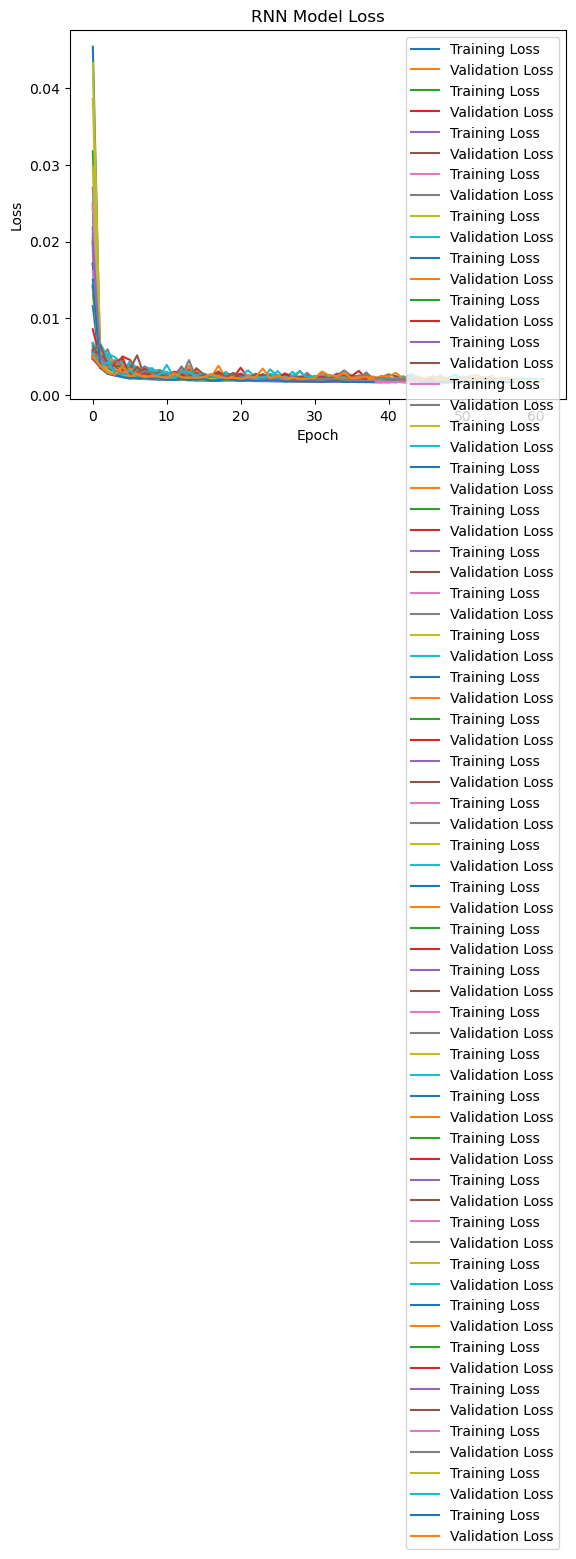

In [24]:
sequence_lengths = [10, 20, 30]
hidden_sizes = [32, 64, 128, 256]
num_layers = [1, 2, 3]
learning_rates = [0.001]

def all_in_one(features, target, sequence_length, hidden_size, num_layers, learning_rate):

    X, y = create_dataset(features, target, sequence_length)
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.float32).to(device)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    test_dataset = CustomDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = EnhancedRNNModel(input_size=X.shape[2], hidden_size=hidden_size, output_size=1, num_layers=num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10, device=device)
    predictions, actuals = evaluate_model(model, test_loader, scaler_target)

    plot_performance(train_losses, val_losses, predictions, actuals, title = f'LSTM_Model_Seq_{sequence_length}_Hidden_{hidden_size}_Layers_{num_layers}_LR_{learning_rate}')
    rmse, mae = calculate_metrics(predictions, actuals)

    return rmse, mae

# Implementing grid search for hyperparameter tuning
results = []
for seq_len in sequence_lengths:
    for hidden_size in hidden_sizes:
        for num_layer in num_layers:
            for lr in learning_rates:
                print(f"Training with Seq: {seq_len}, Hidden: {hidden_size}, Layers: {num_layer}, LR: {lr}")
                rmse, mae = all_in_one(combined_features, target_scaled, seq_len, hidden_size, num_layer, lr)
                results.append((seq_len, hidden_size, num_layer, lr, rmse, mae))
                print(f"RMSE: {rmse}, MAE: {mae}")
                print("-" * 50)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Sequence Length', 'Hidden Size', 'Num Layers', 'Learning Rate', 'RMSE', 'MAE'])
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
